# Дипломный проект. Классификация деталей машиностроительного производства по чертежам.

# Загрузка данных

In [1]:
### подключаем библиотеки
from tensorflow.keras.models import Model # Импортируем модели keras: Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential #Сеть прямого распространения
from tensorflow.keras.layers import SeparableConv2D, add, Input, Conv2DTranspose, Activation, AveragePooling2D, GlobalAveragePooling2D, MaxPooling2D, MaxPooling1D, Conv2D, BatchNormalization, Flatten, Dense, Dropout, Reshape, Conv1D, concatenate # Импортируем стандартные слои keras
from tensorflow.keras import backend as K # Импортируем модуль backend keras'а
from tensorflow.keras.optimizers import Adam # Импортируем оптимизатор Adam
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator # работа с изображениями
import numpy as np # Импортируем библиотеку numpy
from tensorflow.keras.utils import to_categorical #Для представления в формате one_hot_encoding
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image, ImageDraw # Модули работы с изображениями
import time
import random
import os # Импортируем библиотеку os для раоты с фаловой системой
import tensorflow as tf
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing import image # Импортируем модуль image для работы с изображениями
from tensorflow.keras.utils import plot_model # удобный график для визуализации архитектуры модели
#from cv2 import imread
%matplotlib inline

#### проверка графического процессора

In [ ]:
 print(tf.__version__)

2.4.1


In [ ]:
tf.test.is_built_with_cuda()

True

In [ ]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:35_Pacific_Daylight_Time_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.relgpu_drvr445TC445_37.28845127_0


In [ ]:
!nvidia-smi

Tue Jun 29 07:14:39 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 461.40       Driver Version: 461.40       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3070   WDDM  | 00000000:02:00.0  On |                  N/A |
|  0%   45C    P8    27W / 270W |    684MiB /  8192MiB |      8%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Настройка графического процессора для работы со сверточной сетью
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

## Загрузка базы

### CLASS_1 - Детали из листа-резка по контуру
### CLASS_2 - Детали из проката(труба, швеллер, уголок, круг)
### CLASS_3 - Детали тела вращения-токарная обработка 

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Формируем обучающий набор

In [ ]:
# Указываем путь к тренировочному набору
directory = ('/content/drive/MyDrive/УИИ/DIPLOM/BASE-11/TRAIN')

In [ ]:
CLASS = sorted(os.listdir('/content/drive/MyDrive/УИИ/DIPLOM/BASE-11/TRAIN')) # получаем список папок в базе

#Проверяем выгруженные папки
print(CLASS)

['ЛИСТ', 'ПРОКАТ', 'ТОКАРНАЯ']


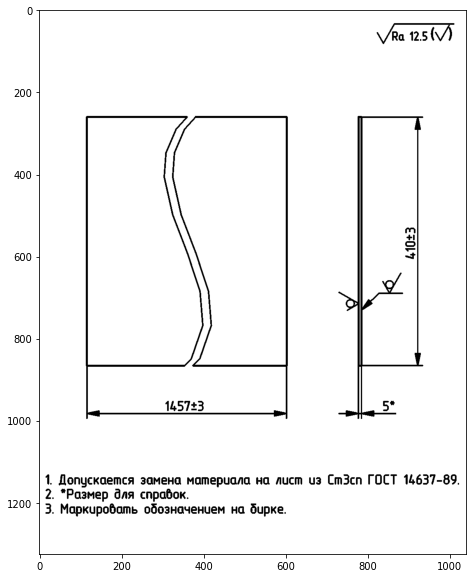

/content/drive/MyDrive/УИИ/DIPLOM/BASE-11/TRAIN/ЛИСТ
(1040, 1325)


In [ ]:
# Формат исходных данных
random_dir = directory + '/' + random.choice(CLASS) # Устанавливаем папку для записи преобразованного изображения, имя файла сохраняем
image1=Image.open(os.path.join(random_dir , random.choice(os.listdir(random_dir))))
grayscale1 = image1.convert('1')
plt.figure(figsize=(20, 10))
plt.imshow(grayscale1)
plt.show()
print(random_dir)
print(image1.size)

In [2]:
# Параметры загружаемых изображений
img_width = 512 # Ширина уменьшенной картинки 
img_height = 384 # Высота уменьшенной картинки 

In [ ]:
#Формируем обучающую выборку
#Создаём пустые листы
x_train = []
y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем классам
for i in range(len(CLASS)):
  g = CLASS[i] #Берём текущий класс
  current_directory = directory + '/' + g
  #Проходим по файлам папки, соответствующей текущему классу
  for filename in sorted(os.listdir(current_directory)): # Проходим по всем файлам в каталоге по указанному пути      
    train_image = image.load_img(os.path.join(current_directory,filename),
                                       target_size=(img_width, img_height)) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size 
    
    alpha = train_image.split()[-1]  # извлекаем только альфаканал
    x_train.append(np.array(alpha)) # преобразуем изображение в массив
    #Добавляем в Y_train номер класса
    y_train.append(i)
  #Выводим информацию о готовности обработки базы
  print("CLASS ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

print ('Количество изображений: ', len(x_train)) # Отображаем количество элементов в обучающей выборке

CLASS ЛИСТ готов -> 373c
CLASS ПРОКАТ готов -> 186c
CLASS ТОКАРНАЯ готов -> 340c
Количество изображений:  2733


In [ ]:
#Превращаем обучающую выборку на numpy массивы
x_train = np.array(x_train)
y_train = np.array(y_train)

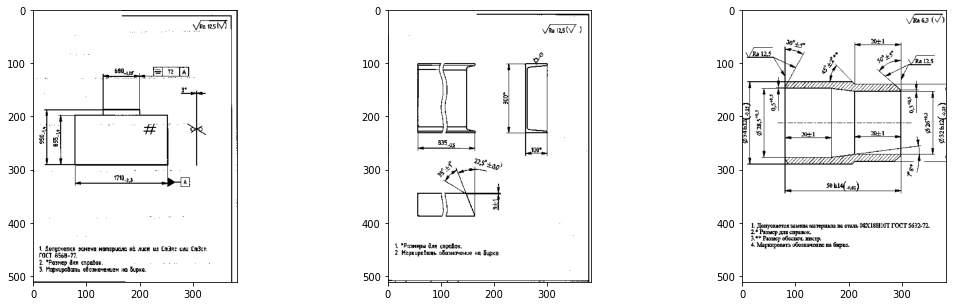

In [ ]:
#Выводим для примера картинки по каждому классу

fig, axs = plt.subplots(1,len(CLASS), figsize=(18, 5)) #Создаем полотно из 10 графиков
for i in range(len(CLASS)): #Проходим по классам от 0 до 3
  label_indexes = np.where(y_train==i)[0] #Получаем список из индексов положений класса i в y_train
  index = random.choice(label_indexes) #Случайным образом выбираем из списка индекс
  img = (x_train[index]) #Выбираем из x_train нужное изображение
  img = np.reshape(img, (img_width, img_height)) #Выводим для примера картинки по каждому класс
  axs[i].imshow(Image.fromarray(img), cmap='gray') #Отображаем изображение i-ым графиков

plt.show() #Показываем изображения

In [ ]:
x_train = x_train.astype('float32') / 255 # представляем x_train в виде значений от 0 до 1
y_train = y_train.astype(np.float32) 
x_train = np.reshape(x_train, (len(x_train), img_width, img_height, 1)) # меняем форму, приводим к нужным нам размерам
y_train = utils.to_categorical(y_train, len(CLASS)) # переводим обучающие лейблы в one-hot кодировку

In [ ]:
print (x_train.shape)
print (y_train.shape)

(2733, 512, 384, 1)
(2733, 3)


## Формируем проверочный набор

In [3]:
# Указываем путь к тренировочному набору
directory_val = ('/content/drive/MyDrive/УИИ/DIPLOM/BASE-11/VAL')

In [6]:
CLASS_val = sorted(os.listdir(r'/content/drive/MyDrive/УИИ/DIPLOM/BASE-11/VAL')) # получаем список папок в базе

#Проверяем выгруженные папки
print(CLASS_val)

['ЛИСТ', 'ПРОКАТ', 'ТОКАРНАЯ']


In [7]:
#Формируем проверочную выборку
#Создаём пустые листы
x_test = []
y_test = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем классам
for i in range(len(CLASS_val)):
  g = CLASS_val[i] #Берём текущий класс
  current_directory = directory_val + '/' + g
  #Проходим по файлам папки, соответствующей текущему классу
  for filename in sorted(os.listdir(current_directory)): # Проходим по всем файлам в каталоге по указанному пути      
    train_image = image.load_img(os.path.join(current_directory,filename),
                                       target_size=(img_width, img_height)) # Читаем очередную картинку и добавляем ее в список изображения с указанным target_size 
    
    alpha = train_image.split()[-1]  # извлекаем только альфаканал
    x_test.append(np.array(alpha)) # преобразуем изображение в массив
    #Добавляем в y_test номер класса
    y_test.append(i)
  #Выводим информацию о готовности обработки базы
  print("CLASS_val ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

print ('Количество изображений: ', len(x_test)) # Отображаем количество элементов в обучающей выборке

CLASS_val ЛИСТ готов -> 45c
CLASS_val ПРОКАТ готов -> 18c
CLASS_val ТОКАРНАЯ готов -> 40c
Количество изображений:  460


In [8]:
#Превращаем обучающую выборку на numpy массивы
x_test = np.array(x_test)
y_test = np.array(y_test)

In [9]:
x_test = x_test.astype('float32') / 255 # представляем x_train в виде значений от 0 до 1
y_test = y_test.astype(np.float32) 
x_test = np.reshape(x_test, (len(x_test), img_width, img_height, 1)) # меняем форму, приводим к нужным нам размерам
y_test = utils.to_categorical(y_test, len(CLASS_val)) # переводим обучающие лейблы в one-hot кодировку

In [ ]:
# x_train - данные для обучения
# x_test - данные для проверки
# y_train - правильные ответы для обучения
# y_test - правильные ответы для проверки
print (x_train.shape)
print (x_test.shape)
print (y_train.shape)
print (y_test.shape)

## Построение модели сети

### Ансамблирование моделей как способ решения.  Суть метода ансамблирования заключается в объединении прогнозов, полученных набором разных моделей, для получения лучшего прогноза. Самый простой способ объединить прогнозы из множества классификаторов (ансамблировать классификаторы) — получить среднее их прогнозов на этапе вывода:
 ---

preds_a = model_a.predict(x_val)

preds_b = model_b.predict(x_val)

preds_c = model_c.predict(x_val)

preds_d = model_d.predict(x_val)

###Лучший классификатор получает больший вес, а худший — меньший. 

final_preds = 0.5 * preds_a + 0.25 * preds_b + 0.1 * preds_c + 0.15 * preds_d 


### model_a

### Последовательная нейронная сеть

In [13]:

#Создаем последовательную модель
def model_a(lr=5e-4,
           img_width = 512, img_height = 384, WS = 5, NK = 1, drop = 2
            ):
    lr = lr
    img_width = img_width
    img_height = img_height
    WS = WS
    NK = NK
    D = drop
    input_shape=(img_width, img_height, 1)
    img_input = Input(input_shape)
    
  
    
    x = Conv2D(8*NK, (WS, WS), padding='same', activation='relu')(img_input)
    x = Conv2D(32*NK, (WS, WS), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(8, 8))(x)
    x = Dropout(0.1*D)(x)

    
    x = Conv2D(64*NK, (WS, WS), padding='same', activation='relu')(x)
    x = Conv2D(128*NK, (WS, WS), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(8, 8))(x)
    x = Dropout(0.1*D)(x)
  

    fin = Flatten()(x)
    fin = Dropout(0.2)(fin) 
    fin = Dense(512*NK, activation='relu')(fin)
    fin = Dense(256*NK, activation='relu')(fin)
    fin = Dense(3, activation='softmax')(fin)


    model = Model(img_input, fin)
    model.compile(optimizer=Adam(lr),
                  loss='categorical_crossentropy',
                  metrics='accuracy')
    
    return model

In [ ]:
model_a_1 = model_a(0.0005, img_width, img_height, 3, 1, 3)
model_a_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 512, 384, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 512, 384, 8)       80        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 384, 32)      2336      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 48, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 48, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 48, 128)       73856 

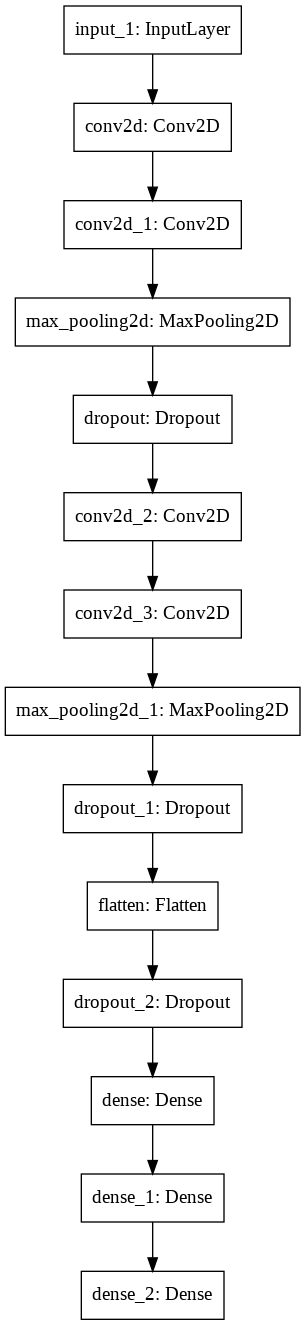

In [ ]:
plot_model(model_a_1, to_file='model_a_1.png') # и построим график для визуализации слоев и связей между ними

In [ ]:
#задаём batch_size
batch_size = 32

In [ ]:
weights_file_a = '/content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_a_1_weight.tf'

In [ ]:
callbacks_list_a = [ 
 callbacks.EarlyStopping(
 monitor='val_accuracy', 
 patience=12, 
 ),
 callbacks.ReduceLROnPlateau(
 monitor='val_loss',
 factor = 0.5,
 patience=5, 
 ),
 callbacks.ModelCheckpoint(weights_file_a,
 monitor='val_loss',                           
 save_best_only=True, 
 )
]

Epoch 1/100
86/86 [==============================] - 57s 285ms/step - loss: 0.9489 - accuracy: 0.5510 - val_loss: 0.9138 - val_accuracy: 0.6087
INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_a_1_weight.tf/assets
Epoch 2/100
86/86 [==============================] - 22s 256ms/step - loss: 0.7606 - accuracy: 0.6736 - val_loss: 0.6804 - val_accuracy: 0.7457
INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_a_1_weight.tf/assets
Epoch 3/100
86/86 [==============================] - 22s 255ms/step - loss: 0.5990 - accuracy: 0.7567 - val_loss: 0.6396 - val_accuracy: 0.7261
INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_a_1_weight.tf/assets
Epoch 4/100
86/86 [==============================] - 22s 254ms/step - loss: 0.4811 - accuracy: 0.8119 - val_loss: 0.4319 - val_accuracy: 0.8304
INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_a_1_weight.tf/assets


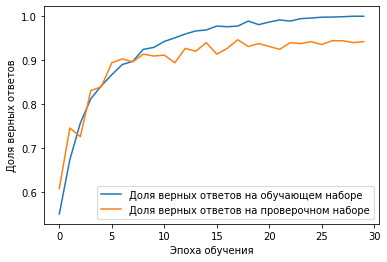

In [ ]:
#Обучаем сеть на данных 
history = model_a_1.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=100,
                    callbacks=callbacks_list_a,
                    validation_data=(x_test, y_test),
                    verbose=1)

#Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### model_b

###  Модель с остаточными связими: повторное внедрение предыдущей исходящей информации  метод add

In [14]:


def model_b(lr=5e-4,
           img_width = 512, img_height = 384, WS = 5, NK = 1, drop = 2
            ):
    lr = lr
    img_width = img_width
    img_height = img_height
    WS = WS
    NK = NK
    D = drop
    input_shape=(img_width, img_height, 1)
    img_input = Input(input_shape)

    # Блок 1
    
    x = Conv2D(8*NK, (WS, WS), padding='same', activation='relu')(img_input)
    x = Conv2D(32*NK, (WS, WS), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(8, 8))(x)
    x = Dropout(0.1*D)(x)

    
    x = Conv2D(64*NK, (WS, WS), padding='same', activation='relu')(x)
    x = Conv2D(128*NK, (WS, WS), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(8, 8))(x)
    x = Dropout(0.1*D)(x)


    # Блок 2
    x2 = Conv2D(512*NK, (WS, WS), padding='same', activation='relu')(x)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.1*D)(x2)
    x2f = Reshape((8, 6, 128), input_shape = (4, 3, 512))(x2)
    


    

    fin = add([x, x2f])
    #fin = concatenate([x, x2f, x3f])


   
    
    fin = Flatten()(fin)
    fin = Dropout(0.1*D)(fin)
    fin = Dense(512, activation='relu')(fin)
    fin = Dense(256, activation='relu')(fin)
    fin = Dense(3, activation='softmax')(fin)


    model = Model(img_input, fin)
    model.compile(optimizer=Adam(lr),
                  loss='categorical_crossentropy',
                  metrics='accuracy')
    
    return model

In [15]:
model_b_1 = model_b(0.0005, img_width, img_height, 3, 1, 3)
model_b_1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 384, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 384, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 512, 384, 32) 2336        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 48, 32)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

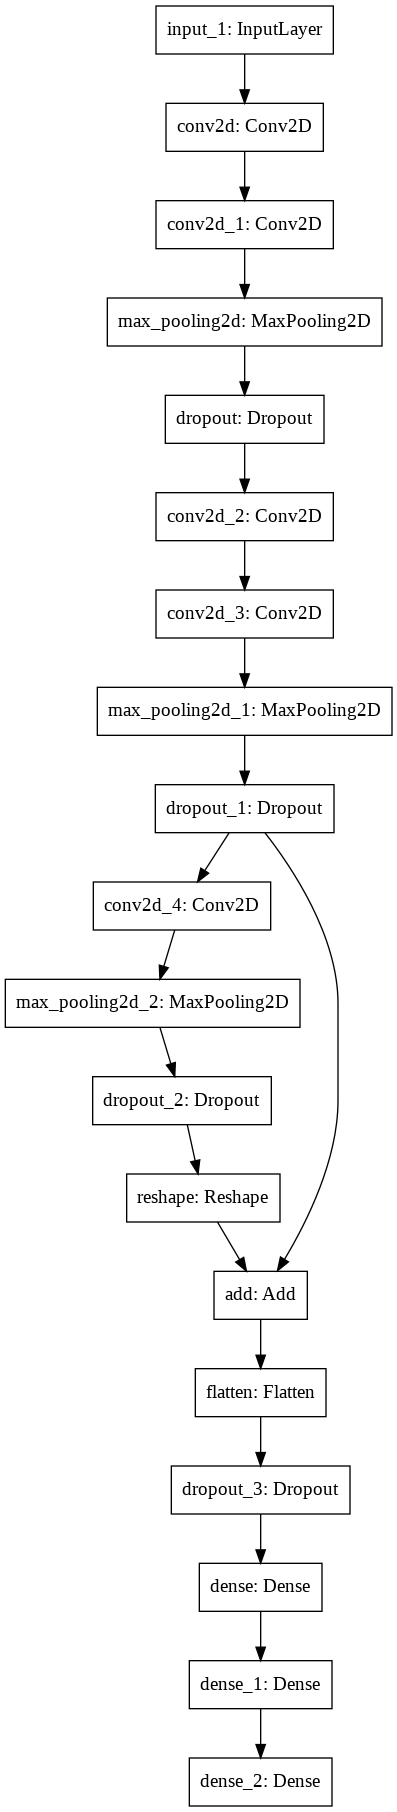

In [16]:
plot_model(model_b_1, to_file='model_b_1.png') # и построим график для визуализации слоев и связей между ними

In [ ]:
#задаём batch_size
batch_size = 32

In [ ]:
weights_file_b = '/content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf'

In [ ]:
callbacks_list_b = [ 
 callbacks.EarlyStopping(
 monitor='val_accuracy', 
 patience=12, 
 ),
 callbacks.ReduceLROnPlateau(
 monitor='val_loss',
 factor = 0.5,
 patience=5, 
 ),
 callbacks.ModelCheckpoint(weights_file_b,
 monitor='val_loss',                           
 save_best_only=True, 
 )
]

Epoch 1/100
86/86 [==============================] - 24s 266ms/step - loss: 1.0000 - accuracy: 0.5009 - val_loss: 0.7521 - val_accuracy: 0.6783


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf/assets
Epoch 2/100
86/86 [==============================] - 22s 260ms/step - loss: 0.7691 - accuracy: 0.6652 - val_loss: 0.6557 - val_accuracy: 0.7413


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf/assets
Epoch 3/100
86/86 [==============================] - 22s 259ms/step - loss: 0.6509 - accuracy: 0.7241 - val_loss: 0.5500 - val_accuracy: 0.7935


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf/assets
Epoch 4/100
86/86 [==============================] - 22s 259ms/step - loss: 0.5611 - accuracy: 0.7794 - val_loss: 0.4532 - val_accuracy: 0.8174


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf/assets
Epoch 5/100
86/86 [==============================] - 22s 259ms/step - loss: 0.4563 - accuracy: 0.8244 - val_loss: 0.5033 - val_accuracy: 0.8022
Epoch 6/100
86/86 [==============================] - 22s 259ms/step - loss: 0.4049 - accuracy: 0.8449 - val_loss: 0.3093 - val_accuracy: 0.8848


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf/assets
Epoch 7/100
86/86 [==============================] - 22s 259ms/step - loss: 0.3608 - accuracy: 0.8584 - val_loss: 0.2663 - val_accuracy: 0.8935


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf/assets
Epoch 8/100
86/86 [==============================] - 22s 259ms/step - loss: 0.3043 - accuracy: 0.8833 - val_loss: 0.3047 - val_accuracy: 0.8783
Epoch 9/100
86/86 [==============================] - 22s 258ms/step - loss: 0.2774 - accuracy: 0.8983 - val_loss: 0.2472 - val_accuracy: 0.8978
INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf/assets
Epoch 10/100
86/86 [==============================] - 22s 258ms/step - loss: 0.2475 - accuracy: 0.9001 - val_loss: 0.2708 - val_accuracy: 0.8957
Epoch 11/100
86/86 [==============================] - 22s 259ms/step - loss: 0.2266 - accuracy: 0.9184 - val_loss: 0.2100 - val_accuracy: 0.9065


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf/assets
Epoch 12/100
86/86 [==============================] - 22s 258ms/step - loss: 0.1738 - accuracy: 0.9360 - val_loss: 0.1935 - val_accuracy: 0.9370


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf/assets
Epoch 13/100
86/86 [==============================] - 22s 258ms/step - loss: 0.1959 - accuracy: 0.9268 - val_loss: 0.2180 - val_accuracy: 0.9261
Epoch 14/100
86/86 [==============================] - 22s 258ms/step - loss: 0.1632 - accuracy: 0.9378 - val_loss: 0.1946 - val_accuracy: 0.9261
Epoch 15/100
86/86 [==============================] - 22s 258ms/step - loss: 0.1593 - accuracy: 0.9415 - val_loss: 0.1772 - val_accuracy: 0.9413


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf/assets
Epoch 16/100
86/86 [==============================] - 22s 258ms/step - loss: 0.1275 - accuracy: 0.9576 - val_loss: 0.1884 - val_accuracy: 0.9304
Epoch 17/100
86/86 [==============================] - 22s 258ms/step - loss: 0.1137 - accuracy: 0.9535 - val_loss: 0.2132 - val_accuracy: 0.9196
Epoch 18/100
86/86 [==============================] - 22s 259ms/step - loss: 0.1080 - accuracy: 0.9630 - val_loss: 0.1724 - val_accuracy: 0.9348


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf/assets
Epoch 19/100
86/86 [==============================] - 22s 258ms/step - loss: 0.0869 - accuracy: 0.9682 - val_loss: 0.2203 - val_accuracy: 0.9283
Epoch 20/100
86/86 [==============================] - 22s 258ms/step - loss: 0.0828 - accuracy: 0.9722 - val_loss: 0.2162 - val_accuracy: 0.9370
Epoch 21/100
86/86 [==============================] - 22s 258ms/step - loss: 0.0812 - accuracy: 0.9729 - val_loss: 0.1859 - val_accuracy: 0.9370
Epoch 22/100
86/86 [==============================] - 22s 257ms/step - loss: 0.0487 - accuracy: 0.9828 - val_loss: 0.1893 - val_accuracy: 0.9435
Epoch 23/100
86/86 [==============================] - 22s 258ms/step - loss: 0.0592 - accuracy: 0.9784 - val_loss: 0.1856 - val_accuracy: 0.9500
Epoch 24/100
86/86 [==============================] - 22s 258ms/step - loss: 0.0394 - accuracy: 0.9868 - val_loss: 0.1542 - val_accuracy: 0.9457


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf/assets
Epoch 25/100
86/86 [==============================] - 22s 258ms/step - loss: 0.0417 - accuracy: 0.9868 - val_loss: 0.1657 - val_accuracy: 0.9370
Epoch 26/100
86/86 [==============================] - 22s 257ms/step - loss: 0.0288 - accuracy: 0.9894 - val_loss: 0.1939 - val_accuracy: 0.9391
Epoch 27/100
86/86 [==============================] - 22s 257ms/step - loss: 0.0184 - accuracy: 0.9930 - val_loss: 0.2102 - val_accuracy: 0.9348
Epoch 28/100
86/86 [==============================] - 22s 257ms/step - loss: 0.0253 - accuracy: 0.9916 - val_loss: 0.1506 - val_accuracy: 0.9500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf/assets
Epoch 29/100
86/86 [==============================] - 22s 257ms/step - loss: 0.0259 - accuracy: 0.9905 - val_loss: 0.1467 - val_accuracy: 0.9391


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf/assets
Epoch 30/100
86/86 [==============================] - 22s 258ms/step - loss: 0.0187 - accuracy: 0.9923 - val_loss: 0.1689 - val_accuracy: 0.9478
Epoch 31/100
86/86 [==============================] - 22s 258ms/step - loss: 0.0192 - accuracy: 0.9916 - val_loss: 0.1617 - val_accuracy: 0.9478
Epoch 32/100
86/86 [==============================] - 22s 257ms/step - loss: 0.0204 - accuracy: 0.9930 - val_loss: 0.2128 - val_accuracy: 0.9413
Epoch 33/100
86/86 [==============================] - 22s 258ms/step - loss: 0.0184 - accuracy: 0.9930 - val_loss: 0.1457 - val_accuracy: 0.9543


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf/assets
Epoch 34/100
86/86 [==============================] - 22s 258ms/step - loss: 0.0157 - accuracy: 0.9952 - val_loss: 0.1547 - val_accuracy: 0.9543
Epoch 35/100
86/86 [==============================] - 22s 258ms/step - loss: 0.0087 - accuracy: 0.9971 - val_loss: 0.1700 - val_accuracy: 0.9543
Epoch 36/100
86/86 [==============================] - 22s 257ms/step - loss: 0.0233 - accuracy: 0.9923 - val_loss: 0.1527 - val_accuracy: 0.9500
Epoch 37/100
86/86 [==============================] - 22s 258ms/step - loss: 0.0210 - accuracy: 0.9923 - val_loss: 0.2095 - val_accuracy: 0.9435
Epoch 38/100
86/86 [==============================] - 22s 257ms/step - loss: 0.0186 - accuracy: 0.9952 - val_loss: 0.1790 - val_accuracy: 0.9413
Epoch 39/100
86/86 [==============================] - 22s 257ms/step - loss: 0.0171 - accuracy: 0.9941 - val_loss: 0.1753 - val_accuracy: 0.9500
Epoch 40/100
86/86 [====

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf/assets
Epoch 43/100
86/86 [==============================] - 22s 258ms/step - loss: 0.0080 - accuracy: 0.9978 - val_loss: 0.1497 - val_accuracy: 0.9522
Epoch 44/100
86/86 [==============================] - 22s 258ms/step - loss: 0.0134 - accuracy: 0.9960 - val_loss: 0.1678 - val_accuracy: 0.9478
Epoch 45/100
86/86 [==============================] - 22s 258ms/step - loss: 0.0062 - accuracy: 0.9985 - val_loss: 0.1973 - val_accuracy: 0.9500


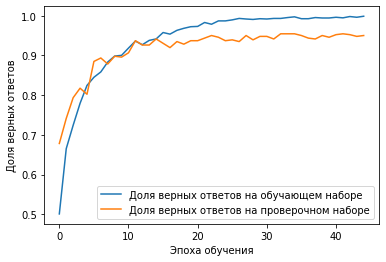

In [ ]:
#Обучаем сеть на данных 
history = model_b_1.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=100,
                    callbacks=callbacks_list_b,
                    validation_data=(x_test, y_test),
                    verbose=1)

#Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### model_c

### Модель с остаточными связими: повторное внедрение предыдущей исходящей информации  метод concantenate

In [17]:

def model_c(lr=5e-4,
           img_width = 512, img_height = 384, WS = 5, NK = 1, drop = 2
            ):
    lr = lr
    img_width = img_width
    img_height = img_height
    WS = WS
    NK = NK
    D = drop
    input_shape=(img_width, img_height, 1)
    img_input = Input(input_shape)
    
    #x = Reshape((512, 384, 4), input_shape = (img_width, img_height, 1))(img_input) 
    
    # Блок 1
    
    x = Conv2D(8*NK, (WS, WS), padding='same', activation='relu')(img_input)
    x = Conv2D(16*NK, (WS, WS), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(8, 8))(x)
    x = Dropout(0.1*D)(x)

    
    x = Conv2D(32*NK, (WS, WS), padding='same', activation='relu')(x)
    x = Conv2D(64*NK, (WS, WS), padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=(8, 8))(x)
    x = Dropout(0.1*D)(x)


    # Блок 2
    x2 = Conv2D(256*NK, (WS, WS), padding='same', activation='relu')(x)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.1*D)(x2)
    x2f = Reshape((8, 6, 64), input_shape = (4, 3, 256))(x2)

    # Блок 3
    x3 = Conv2D(1536*NK, (WS, WS), padding='same', activation='relu')(x2)
    x3 = MaxPooling2D(pool_size=(2, 2))(x3)
    x3 = Dropout(0.1*D)(x3)
    x3f = Reshape((8, 6, 64), input_shape = (2, 1, 1536))(x3)
    

    

    #fin = add([x, x2f, x3f])
    fin = concatenate([x, x2f, x3f])

    
    fin = Flatten()(fin)
    fin = Dropout(0.2)(fin) 
    fin = Dense(256*NK, activation='relu')(fin)
    fin = Dense(128*NK, activation='relu')(fin)
    fin = Dense(3, activation='softmax')(fin)


    model = Model(img_input, fin)
    model.compile(optimizer=Adam(lr),
                  loss='categorical_crossentropy',
                  metrics='accuracy')
    
    return model

In [18]:
model_c_1 = model_c(0.0005, img_width, img_height, 3, 1, 3)
model_c_1.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 384, 1) 0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 512, 384, 8)  80          input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 512, 384, 16) 1168        conv2d_5[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 64, 48, 16)   0           conv2d_6[0][0]                   
____________________________________________________________________________________________

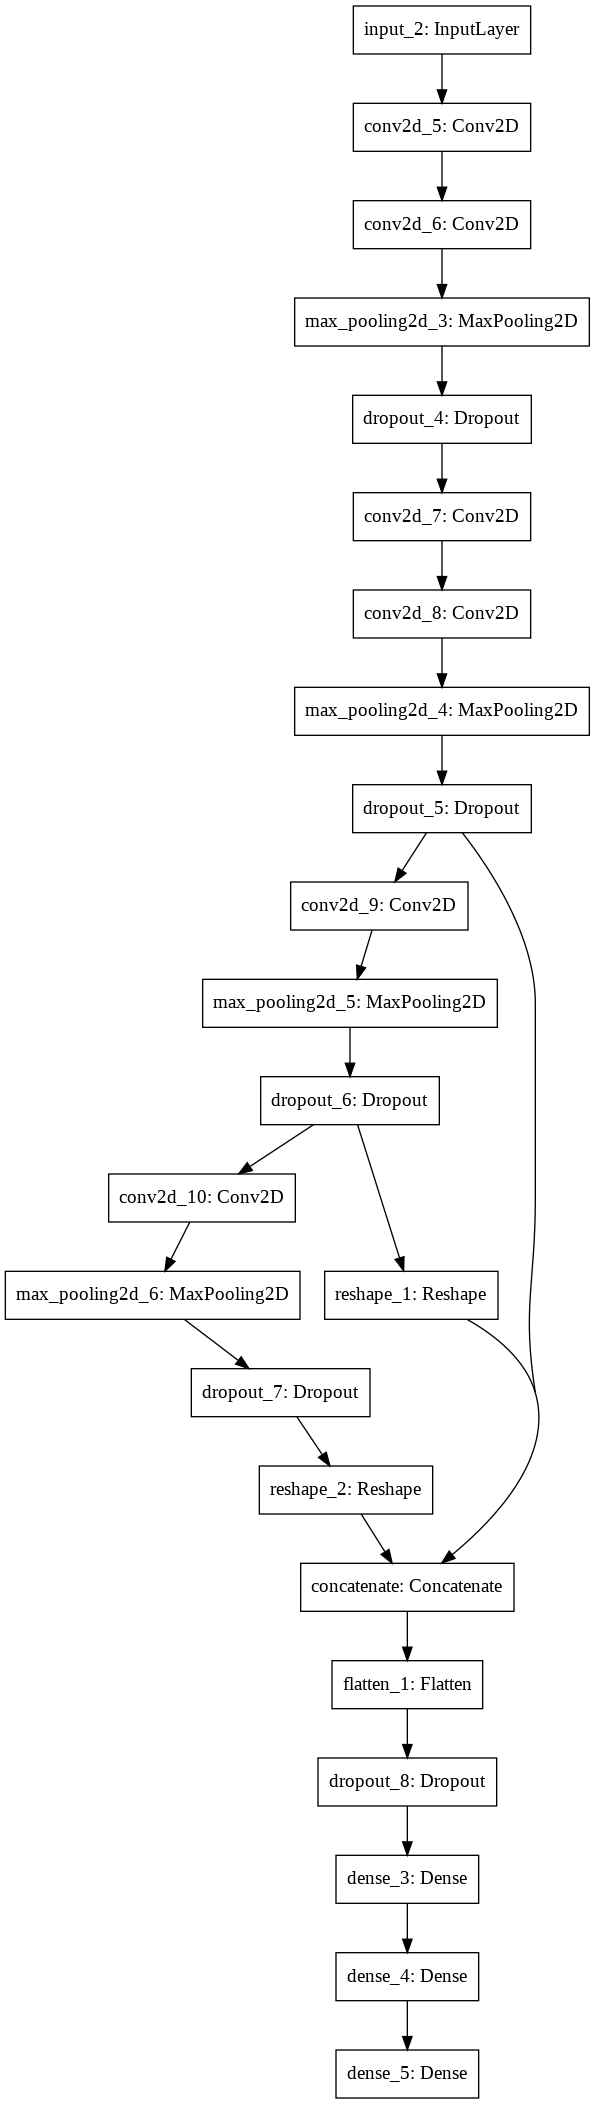

In [19]:
plot_model(model_c_1, to_file='model_c_1.png') # и построим график для визуализации слоев и связей между ними

In [ ]:
#задаём batch_size
batch_size = 32

In [ ]:
weights_file_c = '/content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_c_1_weight.tf'

In [ ]:
callbacks_list_c = [ 
 callbacks.EarlyStopping(
 monitor='val_accuracy', 
 patience=12, 
 ),
 callbacks.ReduceLROnPlateau(
 monitor='val_loss',
 factor = 0.5,
 patience=5, 
 ),
 callbacks.ModelCheckpoint(weights_file_c, 
 monitor='val_loss',
 save_best_only=True, 
 )
]

Epoch 1/100
86/86 [==============================] - 20s 222ms/step - loss: 0.9787 - accuracy: 0.5254 - val_loss: 0.7982 - val_accuracy: 0.6783
INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_c_1_weight.tf/assets
Epoch 2/100
86/86 [==============================] - 19s 218ms/step - loss: 0.7613 - accuracy: 0.6630 - val_loss: 0.6458 - val_accuracy: 0.7326
INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_c_1_weight.tf/assets
Epoch 3/100
86/86 [==============================] - 19s 216ms/step - loss: 0.6588 - accuracy: 0.7278 - val_loss: 0.6755 - val_accuracy: 0.7261
Epoch 4/100
86/86 [==============================] - 19s 216ms/step - loss: 0.5445 - accuracy: 0.7772 - val_loss: 0.4735 - val_accuracy: 0.8217
INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_c_1_weight.tf/assets
Epoch 5/100
86/86 [==============================] - 19s 217ms/step - loss: 0.5099 - accuracy: 0.7977 - va

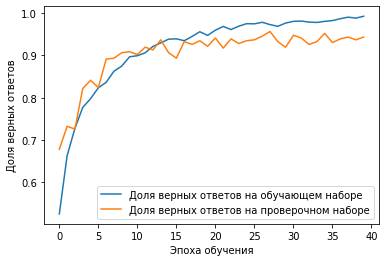

In [ ]:
#Обучаем сеть на данных 
history = model_c_1.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=100,
                    callbacks=callbacks_list_c,
                    validation_data=(x_test, y_test),
                    verbose=1)

#Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

### model_d

### Mодель с несколькими параллельными сверточными ветвями

In [20]:

def model_d2(lr=5e-4,
           img_width = 512, img_height = 394, WS = 5, NK = 1, drop = 2
            ):
    lr = lr
    img_width = img_width
    img_height = img_height
    WS = WS
    NK = NK
    D = drop
    input_shape=(img_width, img_height, 1)
    img_input = Input(input_shape)

    
    # Блок 1
    
    x1 = Conv2D(8*NK, (WS, WS), padding='same', activation='relu')(img_input)
    x1 = Conv2D(32*NK, (WS, WS), padding='same', activation='relu')(x1)
    x1 = MaxPooling2D(pool_size=(8, 8))(x1)
    x1 = Dropout(0.1*D)(x1)

    
    x1 = Conv2D(64*NK, (WS, WS), padding='same', activation='relu')(x1)
    x1 = Conv2D(128*NK, (WS, WS), padding='same', activation='relu')(x1)
    x1 = MaxPooling2D(pool_size=(8, 8))(x1)
    x1 = Dropout(0.1*D)(x1)

    # Блок 2

    x2 = Conv2D(512*NK, (WS, WS), padding='same', activation='relu')(x1)
    x2 = MaxPooling2D(pool_size=(2, 2))(x2)
    x2 = Dropout(0.1*D)(x2)
    x2 = Reshape((8, 6, 128), input_shape = (4, 3, 512))(x2)
    
    # Блок 3

    x3 = Conv2D(8*NK, (WS, WS), padding='same', activation='relu')(img_input)
    x3 = Conv2D(32*NK, (WS, WS), padding='same', activation='relu')(x3)
    x3 = MaxPooling2D(pool_size=(16, 16))(x3)
    x3 = Dropout(0.1*D)(x3)

    
    x3 = Conv2D(128*NK, (WS, WS), padding='same', activation='relu')(x3)
    x3 = Conv2D(576*NK, (WS, WS), padding='same', activation='relu')(x3)
    x3 = MaxPooling2D(pool_size=(16, 16))(x3)
    x3 = Dropout(0.1*D)(x3)
    x3 = Reshape((8, 6, 24), input_shape = (2, 1, 576))(x3)

    fin1 = add([x1, x2])
    fin2 = concatenate([fin1, x3], axis=-1)

   
    
    fin = Flatten()(fin2)
    fin = Dropout(0.1*D)(fin)
    fin = Dense(512, activation='relu')(fin)
    fin = Dense(256, activation='relu')(fin)
    fin = Dense(3, activation='softmax')(fin)


    model = Model(img_input, fin)
    model.compile(optimizer=Adam(lr),
                  loss='categorical_crossentropy',
                  metrics='accuracy')
    
    return model

In [21]:
model_d_2 = model_d2(0.0005, img_width, img_height, 3, 1, 3)
model_d_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 384, 1) 0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 512, 384, 8)  80          input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 512, 384, 32) 2336        conv2d_11[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_7 (MaxPooling2D)  (None, 64, 48, 32)   0           conv2d_12[0][0]                  
____________________________________________________________________________________________

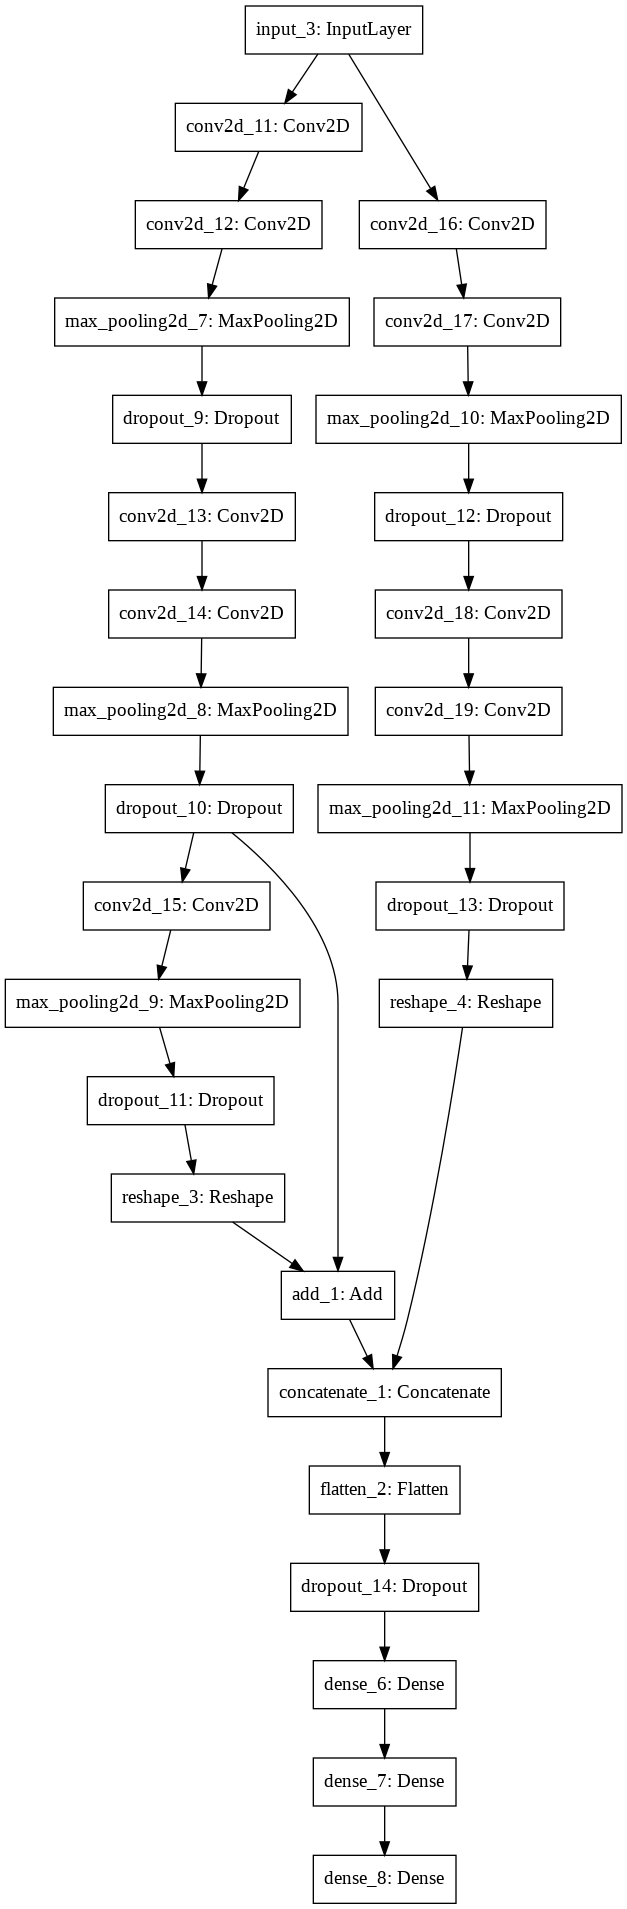

In [22]:
plot_model(model_d_2, to_file='model_d_2.png') # и построим график для визуализации слоев и связей между ними

In [ ]:
#задаём batch_size
batch_size = 32

In [ ]:
weights_file_d2 = '/content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf'

In [ ]:
callbacks_list_d2 = [ 
 callbacks.EarlyStopping(
 monitor='val_accuracy', 
 patience=12, 
 ),
 callbacks.ReduceLROnPlateau(
 monitor='val_loss',
 factor = 0.5,
 patience=5, 
 ),
 callbacks.ModelCheckpoint(weights_file_d2, 
 monitor='val_loss',                           
 save_best_only=True, 
 )
]

Epoch 1/100
86/86 [==============================] - 23s 260ms/step - loss: 1.0750 - accuracy: 0.4299 - val_loss: 0.9124 - val_accuracy: 0.6022


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 2/100
86/86 [==============================] - 22s 260ms/step - loss: 0.8657 - accuracy: 0.6125 - val_loss: 0.7582 - val_accuracy: 0.6804


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 3/100
86/86 [==============================] - 22s 255ms/step - loss: 0.7736 - accuracy: 0.6623 - val_loss: 0.6806 - val_accuracy: 0.7304


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 4/100
86/86 [==============================] - 22s 255ms/step - loss: 0.7094 - accuracy: 0.6992 - val_loss: 0.6341 - val_accuracy: 0.7500


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 5/100
86/86 [==============================] - 22s 258ms/step - loss: 0.6302 - accuracy: 0.7369 - val_loss: 0.6020 - val_accuracy: 0.7674


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 6/100
86/86 [==============================] - 22s 256ms/step - loss: 0.5650 - accuracy: 0.7750 - val_loss: 0.4660 - val_accuracy: 0.8065


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 7/100
86/86 [==============================] - 22s 256ms/step - loss: 0.4826 - accuracy: 0.8167 - val_loss: 0.3925 - val_accuracy: 0.8478


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 8/100
86/86 [==============================] - 22s 256ms/step - loss: 0.4167 - accuracy: 0.8427 - val_loss: 0.3618 - val_accuracy: 0.8565


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 9/100
86/86 [==============================] - 22s 256ms/step - loss: 0.3564 - accuracy: 0.8584 - val_loss: 0.3067 - val_accuracy: 0.8826


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 10/100
86/86 [==============================] - 22s 257ms/step - loss: 0.3163 - accuracy: 0.8844 - val_loss: 0.2705 - val_accuracy: 0.8978


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 11/100
86/86 [==============================] - 22s 256ms/step - loss: 0.2693 - accuracy: 0.8979 - val_loss: 0.2420 - val_accuracy: 0.9065


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 12/100
86/86 [==============================] - 22s 256ms/step - loss: 0.2436 - accuracy: 0.9071 - val_loss: 0.2901 - val_accuracy: 0.8826
Epoch 13/100
86/86 [==============================] - 22s 256ms/step - loss: 0.2091 - accuracy: 0.9217 - val_loss: 0.3086 - val_accuracy: 0.9000
Epoch 14/100
86/86 [==============================] - 22s 256ms/step - loss: 0.2012 - accuracy: 0.9232 - val_loss: 0.2568 - val_accuracy: 0.8870
Epoch 15/100
86/86 [==============================] - 22s 255ms/step - loss: 0.1749 - accuracy: 0.9319 - val_loss: 0.2130 - val_accuracy: 0.9217


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 16/100
86/86 [==============================] - 22s 256ms/step - loss: 0.1476 - accuracy: 0.9411 - val_loss: 0.2053 - val_accuracy: 0.9196


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 17/100
86/86 [==============================] - 22s 256ms/step - loss: 0.1324 - accuracy: 0.9499 - val_loss: 0.1715 - val_accuracy: 0.9457


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 18/100
86/86 [==============================] - 22s 255ms/step - loss: 0.1296 - accuracy: 0.9532 - val_loss: 0.1798 - val_accuracy: 0.9370
Epoch 19/100
86/86 [==============================] - 22s 256ms/step - loss: 0.0937 - accuracy: 0.9645 - val_loss: 0.2025 - val_accuracy: 0.9413
Epoch 20/100
86/86 [==============================] - 22s 255ms/step - loss: 0.0950 - accuracy: 0.9652 - val_loss: 0.2147 - val_accuracy: 0.9087
Epoch 21/100
86/86 [==============================] - 22s 254ms/step - loss: 0.0868 - accuracy: 0.9689 - val_loss: 0.2115 - val_accuracy: 0.9348
Epoch 22/100
86/86 [==============================] - 22s 255ms/step - loss: 0.0846 - accuracy: 0.9674 - val_loss: 0.1988 - val_accuracy: 0.9413
Epoch 23/100
86/86 [==============================] - 22s 255ms/step - loss: 0.0649 - accuracy: 0.9715 - val_loss: 0.1607 - val_accuracy: 0.9413


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 24/100
86/86 [==============================] - 22s 255ms/step - loss: 0.0364 - accuracy: 0.9898 - val_loss: 0.1496 - val_accuracy: 0.9478


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 25/100
86/86 [==============================] - 22s 255ms/step - loss: 0.0403 - accuracy: 0.9850 - val_loss: 0.1470 - val_accuracy: 0.9522


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 26/100
86/86 [==============================] - 22s 256ms/step - loss: 0.0333 - accuracy: 0.9879 - val_loss: 0.1622 - val_accuracy: 0.9435
Epoch 27/100
86/86 [==============================] - 22s 256ms/step - loss: 0.0367 - accuracy: 0.9857 - val_loss: 0.1501 - val_accuracy: 0.9522
Epoch 28/100
86/86 [==============================] - 22s 255ms/step - loss: 0.0339 - accuracy: 0.9890 - val_loss: 0.1638 - val_accuracy: 0.9435
Epoch 29/100
86/86 [==============================] - 22s 255ms/step - loss: 0.0268 - accuracy: 0.9898 - val_loss: 0.1694 - val_accuracy: 0.9435
Epoch 30/100
86/86 [==============================] - 22s 256ms/step - loss: 0.0305 - accuracy: 0.9898 - val_loss: 0.1860 - val_accuracy: 0.9435
Epoch 31/100
86/86 [==============================] - 22s 255ms/step - loss: 0.0229 - accuracy: 0.9920 - val_loss: 0.1457 - val_accuracy: 0.9478


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 32/100
86/86 [==============================] - 22s 256ms/step - loss: 0.0139 - accuracy: 0.9960 - val_loss: 0.1407 - val_accuracy: 0.9543


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 33/100
86/86 [==============================] - 22s 256ms/step - loss: 0.0229 - accuracy: 0.9923 - val_loss: 0.1410 - val_accuracy: 0.9565
Epoch 34/100
86/86 [==============================] - 22s 256ms/step - loss: 0.0169 - accuracy: 0.9945 - val_loss: 0.1298 - val_accuracy: 0.9543


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf/assets
Epoch 35/100
86/86 [==============================] - 22s 255ms/step - loss: 0.0153 - accuracy: 0.9952 - val_loss: 0.1442 - val_accuracy: 0.9609
Epoch 36/100
86/86 [==============================] - 22s 255ms/step - loss: 0.0114 - accuracy: 0.9963 - val_loss: 0.1536 - val_accuracy: 0.9565
Epoch 37/100
86/86 [==============================] - 22s 255ms/step - loss: 0.0188 - accuracy: 0.9956 - val_loss: 0.1514 - val_accuracy: 0.9500
Epoch 38/100
86/86 [==============================] - 22s 256ms/step - loss: 0.0149 - accuracy: 0.9949 - val_loss: 0.1472 - val_accuracy: 0.9543
Epoch 39/100
86/86 [==============================] - 22s 256ms/step - loss: 0.0086 - accuracy: 0.9982 - val_loss: 0.1476 - val_accuracy: 0.9630
Epoch 40/100
86/86 [==============================] - 22s 255ms/step - loss: 0.0119 - accuracy: 0.9960 - val_loss: 0.1821 - val_accuracy: 0.9413
Epoch 41/100
86/86 [====

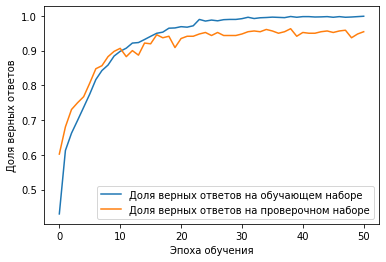

In [ ]:
#Обучаем сеть на данных 
history = model_d_2.fit(x_train, 
                    y_train, 
                    batch_size=batch_size, 
                    epochs=100,
                    callbacks=callbacks_list_d2,
                    validation_data=(x_test, y_test),
                    verbose=1)

#Отображаем график точности обучения
plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

## Оценка работы нейронной сети 

### Оценка моделей

In [23]:
Model_a = load_model('/content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_a_1_weight.tf')

In [24]:
test_loss, test_acc = Model_a.evaluate(x_test, y_test)
print(test_loss)
print(test_acc)

15/15 [==============================] - 27s 2s/step - loss: 0.1863 - accuracy: 0.9457
0.18634265661239624
0.945652186870575


In [25]:
Model_b = load_model('/content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_b_1_weight.tf')

In [26]:
test_loss, test_acc = Model_b.evaluate(x_test, y_test)
print(test_loss)
print(test_acc)

15/15 [==============================] - 28s 2s/step - loss: 0.1417 - accuracy: 0.9543
0.14173687994480133
0.9543478488922119


In [27]:
Model_c = load_model('/content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_c_1_weight.tf')

In [28]:
test_loss, test_acc = Model_c.evaluate(x_test, y_test)
print(test_loss)
print(test_acc)

15/15 [==============================] - 21s 1s/step - loss: 0.1627 - accuracy: 0.9478
0.16269312798976898
0.947826087474823


In [29]:
Model_d = load_model('/content/drive/MyDrive/УИИ/DIPLOM/PP/LAYERS/model_d_2_weight.tf')

In [30]:
test_loss, test_acc = Model_d.evaluate(x_test, y_test)
print(test_loss)
print(test_acc)

15/15 [==============================] - 60s 4s/step - loss: 0.1298 - accuracy: 0.9543
0.1298426389694214
0.9543478488922119


In [31]:
preds_a = Model_a.predict(x_test)

In [32]:
preds_b = Model_b.predict(x_test)

In [33]:
preds_c = Model_c.predict(x_test)

In [34]:
preds_d = Model_d.predict(x_test)

In [63]:
final_preds = preds_a*0.15 + preds_b*0.2 + preds_c*0.15 + preds_d*0.5

### Подсчет по группам

In [36]:
# перевод массива предсказаний в списки из названий классов
CLASSES = np.array(CLASS_val)

In [37]:
print(CLASSES)

['ЛИСТ' 'ПРОКАТ' 'ТОКАРНАЯ']


In [38]:
# вывод подсчета правильных ответов по классам
def predsModel(Models):
    Models = Models
    preds = Models.predict(x_test)
    for i in range(len(CLASSES)): #  проходимся по всем классам
        y_label0 = np.array([]) # создаем пустой массив нампай для элементов текущеко класса
        y_label0 = np.where(np.argmax(y_test, axis = -1)==i) # создаем маску из номеров элементов принадлежащих к текущему классу в тестовой выборке
        preds_label0 = np.argmax(preds[y_label0], axis = -1) # применяем маску к массиву содержащему предсказанные элементы
        lenLabel = len(preds_label0) # Размер прверочной выборки по данному классу
        rez = np.sum(preds_label0 != i) # сумма числа элементов из массива предсказаний не равная номеру класса (сумма ответов которые не являеются правильным ответом)
        rez2 = 100 - ((rez*100)/lenLabel) # Процент верно распознанных элементов
        print('Класс', CLASSES[i])
        print('Число элементов = ',' ',lenLabel, 'Число неправильных ответов =  ',rez, 'Распознано верно ', round(rez2,1), '%')
    

### Оценка моделей

In [39]:
# Модель Model_a
predsModel(Model_a)

Класс ЛИСТ
Число элементов =    202 Число неправильных ответов =   9 Распознано верно  95.5 %
Класс ПРОКАТ
Число элементов =    78 Число неправильных ответов =   5 Распознано верно  93.6 %
Класс ТОКАРНАЯ
Число элементов =    180 Число неправильных ответов =   11 Распознано верно  93.9 %


In [40]:
# Модель Model_b
predsModel(Model_b)

Класс ЛИСТ
Число элементов =    202 Число неправильных ответов =   10 Распознано верно  95.0 %
Класс ПРОКАТ
Число элементов =    78 Число неправильных ответов =   7 Распознано верно  91.0 %
Класс ТОКАРНАЯ
Число элементов =    180 Число неправильных ответов =   4 Распознано верно  97.8 %


In [41]:
# Модель Model_c
predsModel(Model_c)

Класс ЛИСТ
Число элементов =    202 Число неправильных ответов =   9 Распознано верно  95.5 %
Класс ПРОКАТ
Число элементов =    78 Число неправильных ответов =   5 Распознано верно  93.6 %
Класс ТОКАРНАЯ
Число элементов =    180 Число неправильных ответов =   10 Распознано верно  94.4 %


In [42]:
# Модель Model_d
predsModel(Model_d)

Класс ЛИСТ
Число элементов =    202 Число неправильных ответов =   7 Распознано верно  96.5 %
Класс ПРОКАТ
Число элементов =    78 Число неправильных ответов =   7 Распознано верно  91.0 %
Класс ТОКАРНАЯ
Число элементов =    180 Число неправильных ответов =   7 Распознано верно  96.1 %


In [64]:
# вывод подсчета правильных ответов по классам итоговой модели : Модель final_preds
preds = final_preds 
for i in range(len(CLASSES)): #  проходимся по всем классам
    y_label0 = np.array([]) # создаем пустой массив нампай для элементов текущеко класса
    y_label0 = np.where(np.argmax(y_test, axis = -1)==i) # создаем маску из номеров элементов принадлежащих к текущему классу в тестовой выборке
    preds_label0 = np.argmax(preds[y_label0], axis = -1) # применяем маску к массиву содержащему предсказанные элементы
    lenLabel = len(preds_label0) # Размер прверочной выборки по данному классу
    rez = np.sum(preds_label0 != i) # сумма числа элементов из массива предсказаний не равная номеру класса (сумма ответов которые не являеются правильным ответом)
    rez2 = 100 - ((rez*100)/lenLabel) # Процент верно распознанных элементов
    print('Класс', CLASSES[i])
    print('Число элементов = ',' ',lenLabel, 'Число неправильных ответов =  ',rez, 'Распознано верно ', round(rez2,1), '%')
    

Класс ЛИСТ
Число элементов =    202 Число неправильных ответов =   4 Распознано верно  98.0 %
Класс ПРОКАТ
Число элементов =    78 Число неправильных ответов =   6 Распознано верно  92.3 %
Класс ТОКАРНАЯ
Число элементов =    180 Число неправильных ответов =   6 Распознано верно  96.7 %


### Вывод: Итоговая модель дает лучший результат чем каждая по отдельности

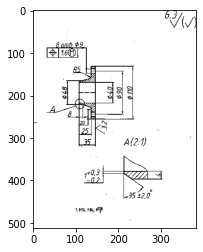

Выход сети:  [4.9201524e-05 6.2232153e-05 9.9988860e-01]
Распознанный образ:  2
Верный ответ:  [0. 0. 1.]
Распознанный образ на картинке:  ТОКАРНАЯ


In [45]:
#Выбираем номер пример
n = np.random.randint(x_test.shape[0])

random_array = np.reshape(x_test[n], (img_width, img_height))
random_array = random_array * 255
random_array = random_array.astype(np.uint8)
random_image = Image.fromarray(random_array)

#Выводим на экран картинку
plt.imshow(random_image.convert('1'))
plt.show()

#Выводим на экран результаты
print("Выход сети: ", final_preds[n])
print("Распознанный образ: ", np.argmax(final_preds[n]))
print("Верный ответ: ", y_test[n])
print("Распознанный образ на картинке: ", CLASS_val[np.argmax(final_preds[n])])

### Вывод нескольких картинок 

In [46]:
# перевод массива в изображение
def array_to_img(immeg, img_width, img_height):
    random_array = np.reshape(immeg, (img_width, img_height))
    random_array = random_array * 255
    random_array = random_array.astype(np.uint8)
    random_image = Image.fromarray(random_array)
    random_image = random_image.convert('1')
    return random_image

In [47]:
# функция для вывода изображений из массива на экран с их предсказанными и актуальными категориями
# n_to_show количество выводимых изображений
# data массив данных для вывода
def show_drow(data, n_to_show = 5): 
    n_to_show = n_to_show
    data = data
    indices = np.random.choice(range(len(data)), n_to_show)
    fig = plt.figure(figsize=(30,6))
    for i, idx in enumerate(indices):
        img = array_to_img(data[idx], img_width, img_height)
        ax = fig.add_subplot(1, n_to_show, i+1)
        ax.axis('off')
        ax.text(0.5, -0.35, 'pred = ' + str(preds_single[idx]), fontsize = 20,
                ha='center', transform=ax.transAxes)
        ax.text(0.5, -0.45, 'act = ' + str(actual_single[idx]), fontsize = 20,
                ha='center', transform=ax.transAxes)
        ax.imshow(img)

In [48]:
preds_single = CLASSES[np.argmax(final_preds, axis = -1)] # массив предсказаний
actual_single = CLASSES[np.argmax(y_test, axis = -1)] # массив y_test

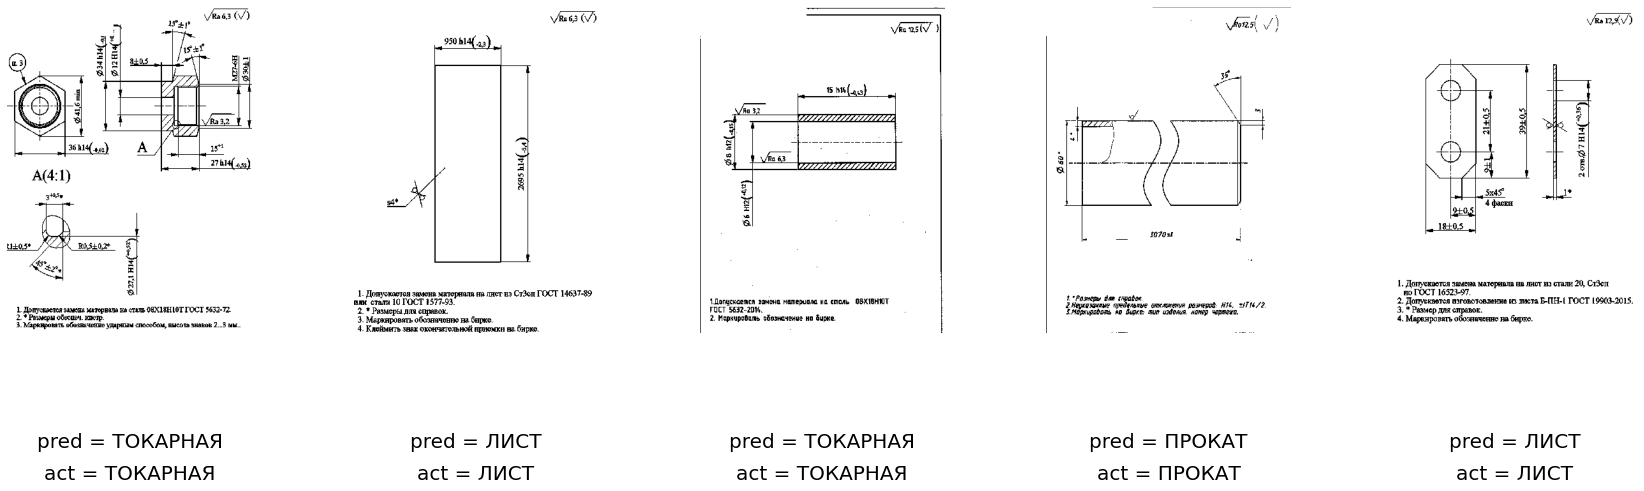

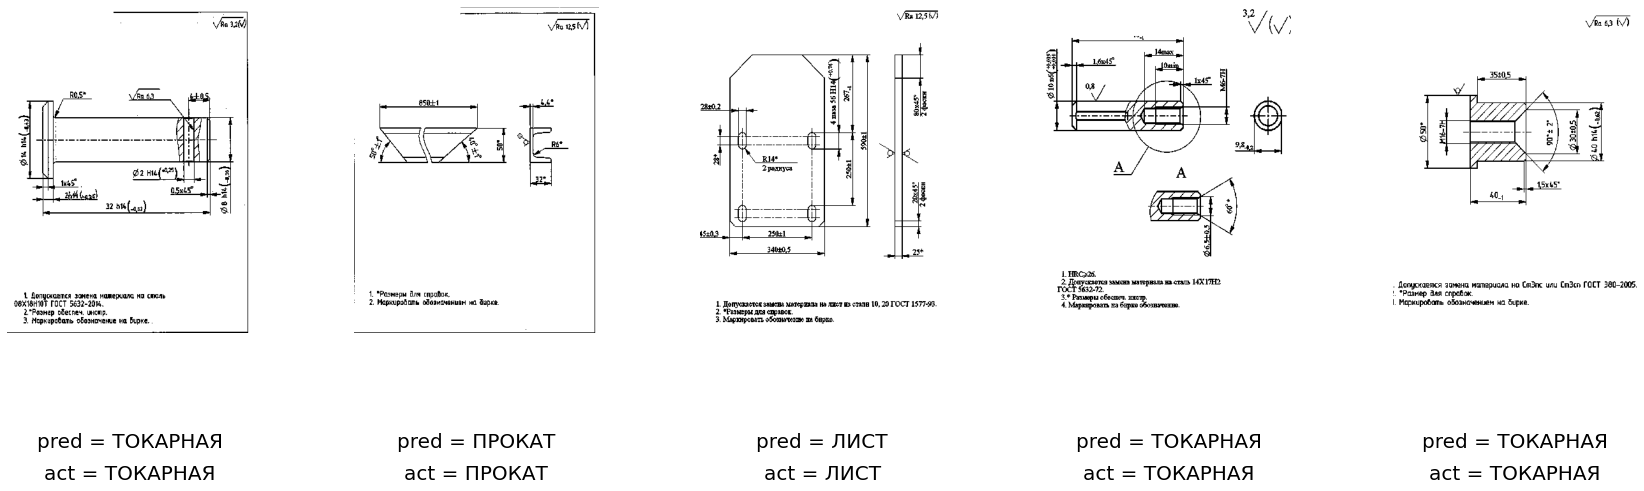

In [49]:
# Выводим 2 раза по 5 изображений
for i in range(2):
    show_drow(x_test, 5)

### Вывод неверно классифицированных изображений по группам

In [50]:
# Получение номеров неправильно распознанных элементов класса в массиве y_test, x_test
# n_class номер класса
# mist_mask_class массив номеров неправильно распознанных элементов класса из 
# mist_mask массив номеров неправильно распознанных элементов данного класса в тестовой выборке y_test, x_test
def mistake_mask(n_class):
    y_label0 = np.array([]) # создаем пустой массив нампай для элементов текущеко класса
    y_label0 = np.where(np.argmax(y_test, axis = -1)==n_class) # создаем маску из номеров элементов принадлежащих к текущему классу в тестовой выборке
    preds_label0 = np.argmax(final_preds[y_label0], axis = -1) # применяем маску к массиву содержащему предсказанные элементы
    mist_mask_class = np.where(preds_label0 != n_class) # формируем список индексов элементов содержащих неправильные ответы (предсказание не равно номеру класса)
    mist_mask = np.take(y_label0, mist_mask_class) # формируем список индексов элементов содержащих неправильные ответы для данного класса в тестовой выборке
    mist_mask = np.reshape(mist_mask, -1)
    return mist_mask

In [51]:
# функция для вывода изображений неправильно предсказанных элементов данного класса
# n_class номер класса
def show_drow_class(n_class):
    take_label = mistake_mask(n_class)               # создаем список с номерами элементов в тестовой выборке в данном классе кот распознаны неверно
    data = x_test[take_label]                        # одбираем их в тестовой выборке
    preds_single_class = preds_single[take_label]    # одбираем их в  массиве предсказаний
    actual_single_class = actual_single[take_label]  # одбираем их в  массиве с правильными ответами
    len_data = data.shape[0]                         # определяем длину массива
    indices = range(len_data)         
    if (len_data//5)== (len_data/5):                 # определяем сколько сетов по 5 картинок необходимо для вывода всех изображений
        x = (len_data/5)
    else:
        x = (len_data//5)+1   
    fig = plt.figure(figsize=(30,11*x))              # выводим  изображения с подписями
    for i, idx in enumerate(indices):
            img = array_to_img(data[idx], img_width, img_height)
            ax = fig.add_subplot(int(x), 5, i+1)
            ax.axis('off')
            ax.text(0.5, -0.35, 'pred = ' + str(preds_single_class[idx]), fontsize = 20,
                    ha='center', transform=ax.transAxes)
            ax.text(0.5, -0.45, 'act = ' + str(actual_single_class[idx]), fontsize = 20,
                    ha='center', transform=ax.transAxes)
            ax.imshow(img)

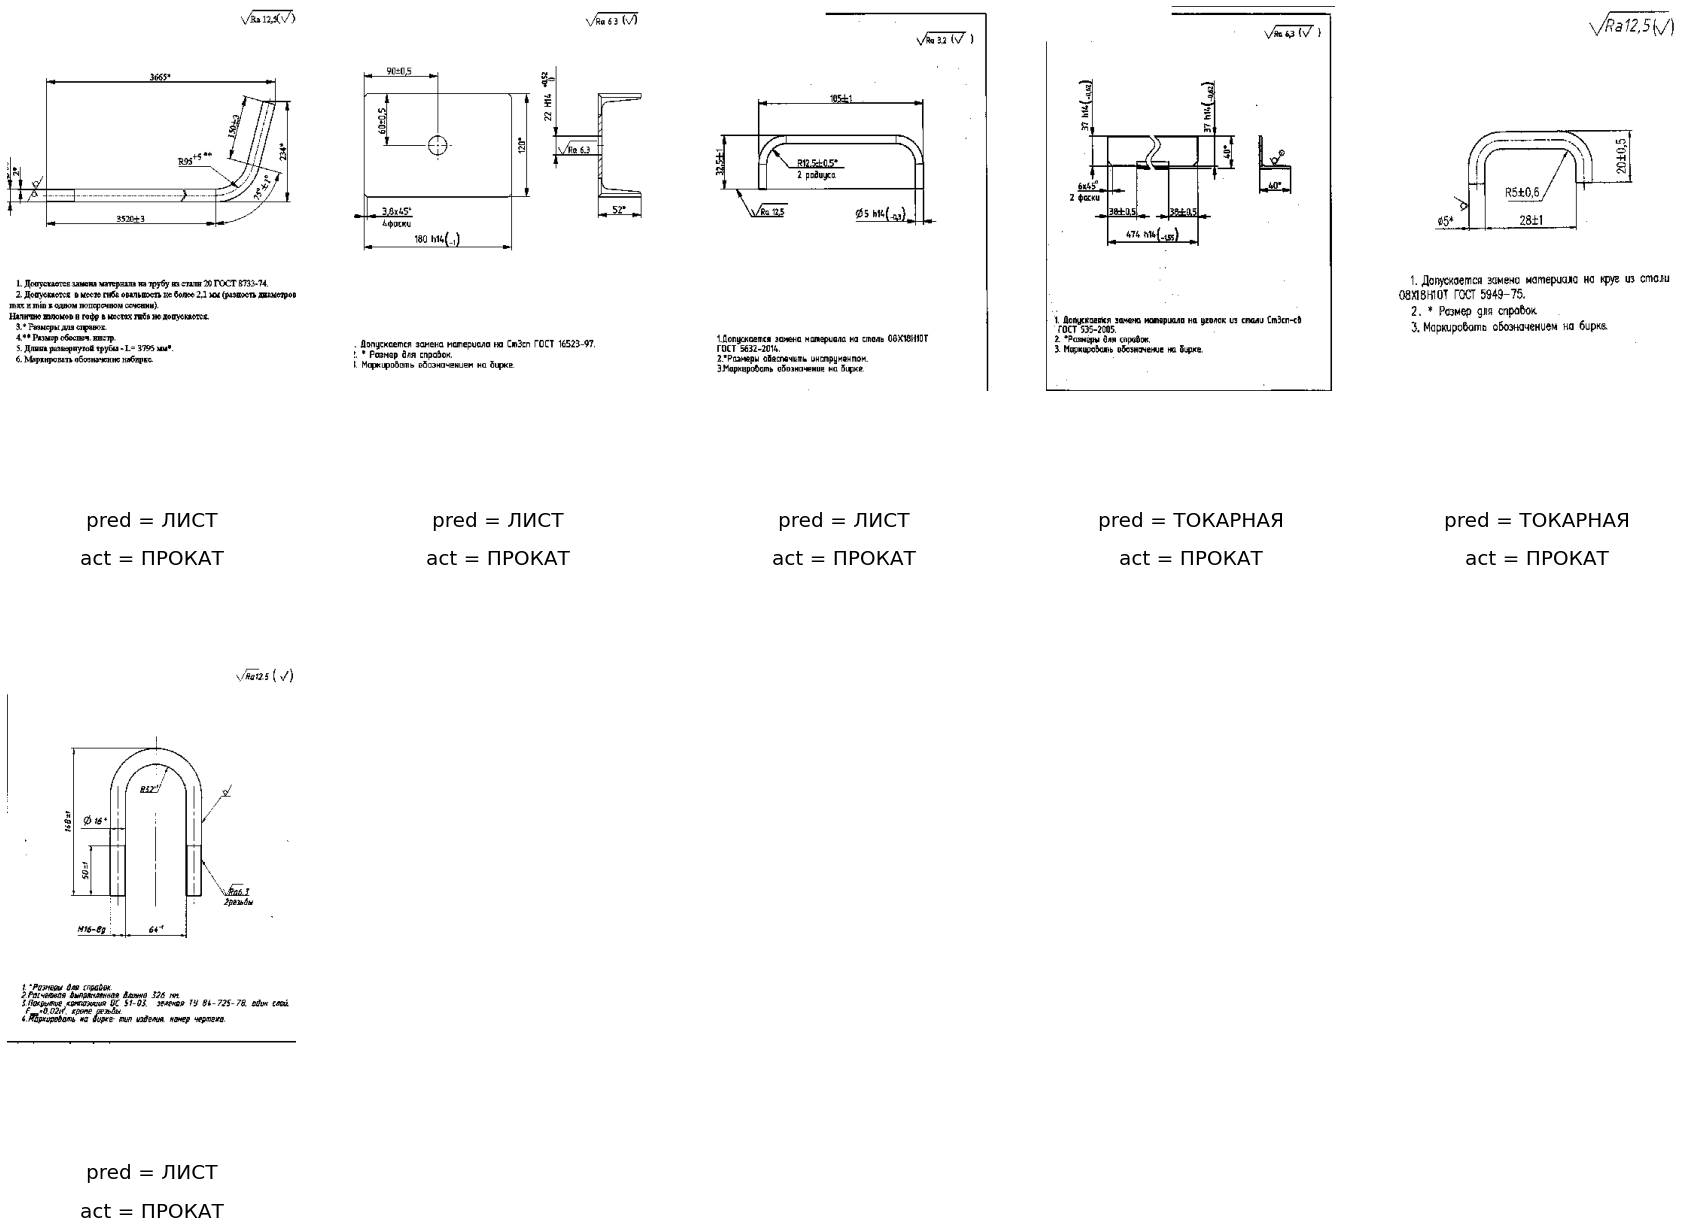

In [52]:
#  вывод изображений неправильно предсказанных элементов  класса 'ПРОКАТ'
show_drow_class(1)